## Variational Inference

The dataset required is small and is available preprocessed here:

- https://drive.google.com/drive/folders/1Tg_3SlKbdv0pDog6k2ys0J79e1-vgRyd?usp=sharing

In [1]:
import torch

from lafomo.datasets import P53Data
from lafomo.variational.kernels import RBF
from lafomo.variational.models import SingleLinearLFM
from lafomo.variational.trainer import P53ConstrainedTrainer
from lafomo.configuration import VariationalConfiguration
from lafomo.utilities.torch import save, load
from lafomo.plot import Plotter

from matplotlib import pyplot as plt

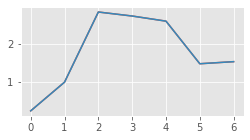

In [2]:
dataset = P53Data(replicate=0, data_dir='../../../data')
num_genes = 5
num_tfs = 1

t_inducing = torch.linspace(0, 12, 12, dtype=torch.float64)
t_observed = torch.linspace(0, 12, 7)
t_predict = torch.linspace(-1, 13, 80, dtype=torch.float64)

plt.figure(figsize=(4, 2))
plt.plot(dataset[0][1])
plt.plot(dataset.m_observed[0, 0])

In [3]:
options = VariationalConfiguration(
    preprocessing_variance=dataset.variance,
    learn_inducing=False,
    num_samples=70,
    kernel_scale=False,
    initial_conditions=False
)
rtol = 5e-2
atol = rtol/10

model_kwargs = {
    'rtol': rtol, 'atol': atol
}
kernel = RBF(dataset.num_latents, scale=options.kernel_scale, dtype=torch.float64)
model = SingleLinearLFM(options, kernel, t_inducing, dataset)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
trainer = P53ConstrainedTrainer(model, optimizer, dataset)
plotter = Plotter(model, dataset.gene_names)

C:\Users\Jacob\Documents\proj\reggae\lafomo\variational\models\model.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.inducing_inputs = Parameter(torch.tensor(t_inducing), requires_grad=options.learn_inducing)


### Outputs prior to training:

C:\Users\Jacob\Documents\proj\reggae\lafomo\plot\plotter.py:108: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(plotnum)


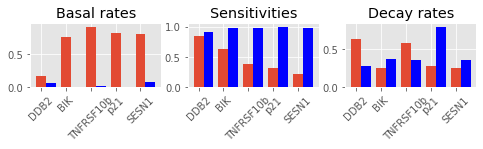

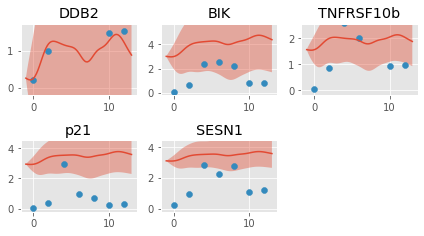

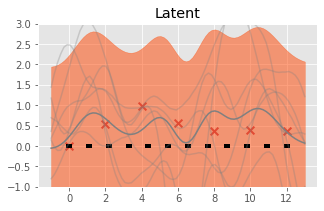

In [4]:
plotter.plot_kinetics()
plotter.plot_outputs(t_predict, replicate=0,
                     t_scatter=dataset.t_observed, y_scatter=dataset.m_observed,
                     model_kwargs=model_kwargs)
plotter.plot_latents(t_predict, ylim=(-1, 3), plot_barenco=True, plot_inducing=False)

In [12]:
tol = 5e-2
import time
start = time.time()

output = trainer.train(50, rtol=tol, atol=tol/10,
                       report_interval=5, plot_interval=5)
end = time.time()
print(end - start)

Epoch 271/320 - Loss: -36.25 (-50.39  14.13  ) λ: 1.76 b: 0.11 d 0.47 s: 1.41
Epoch 276/320 - Loss: -36.63 (-50.61  13.98  ) λ: 1.75 b: 0.11 d 0.47 s: 1.41
Epoch 281/320 - Loss: -36.65 (-50.69  14.04  ) λ: 1.76 b: 0.11 d 0.47 s: 1.41
Epoch 286/320 - Loss: -36.85 (-50.46  13.61  ) λ: 1.76 b: 0.11 d 0.47 s: 1.41
Epoch 291/320 - Loss: -36.74 (-51.02  14.28  ) λ: 1.75 b: 0.11 d 0.46 s: 1.40
Epoch 296/320 - Loss: -36.48 (-50.11  13.63  ) λ: 1.76 b: 0.11 d 0.46 s: 1.40
Epoch 301/320 - Loss: -36.37 (-50.73  14.36  ) λ: 1.77 b: 0.11 d 0.46 s: 1.40
Epoch 306/320 - Loss: -37.38 (-50.73  13.35  ) λ: 1.76 b: 0.11 d 0.46 s: 1.40
Epoch 311/320 - Loss: -36.08 (-50.23  14.16  ) λ: 1.76 b: 0.11 d 0.46 s: 1.39
Epoch 316/320 - Loss: -36.32 (-50.19  13.87  ) λ: 1.77 b: 0.10 d 0.46 s: 1.39
64.78251385688782


### Outputs after training

C:\Users\Jacob\Documents\proj\reggae\lafomo\plot\plotter.py:108: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(plotnum)


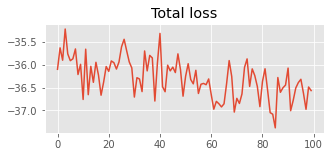

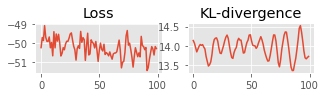

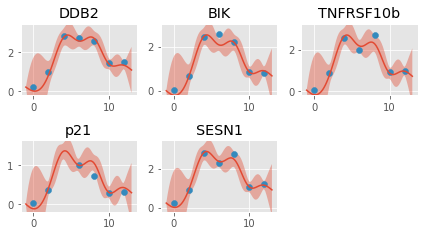

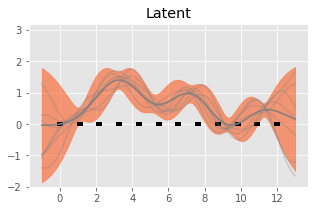

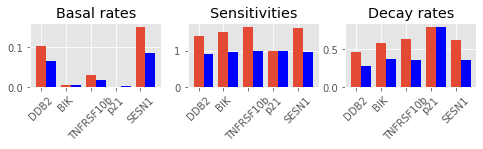

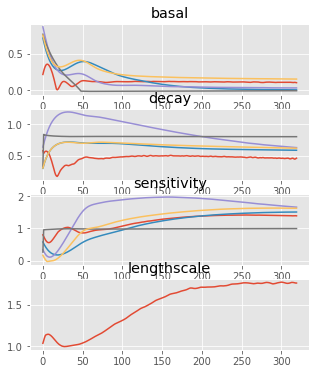

In [13]:
plotter.plot_losses(trainer, last_x=100)
plotter.plot_outputs(t_predict, replicate=0,# ylim=(0, 3),
                     t_scatter=dataset.t_observed,
                     y_scatter=dataset.m_observed,
                     model_kwargs=model_kwargs)
plotter.plot_latents(t_predict, ylim=(-2, 3.2), plot_barenco=False, plot_inducing=False)
plotter.plot_kinetics()
plotter.plot_convergence(trainer)

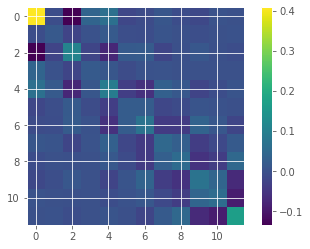

In [8]:
S = torch.tril(torch.stack(trainer.cholS).squeeze())
S = torch.matmul(S, S.transpose(1, 2))
plt.imshow(S[-1])
plt.colorbar()

In [ ]:
plt.imshow(model.Kmm[0].detach())
plt.colorbar()

In [ ]:
print(model.inducing_inputs)

In [ ]:
Ksm = model.kernel(t_predict, model.inducing_inputs)  # (I, T*, Tu)
α = torch.cholesky_solve(Ksm.permute([0, 2, 1]), model.L, upper=False).permute([0, 2, 1])  # (I, T*, Tu)
m_s = torch.matmul(α, model.q_m)  # (I, T*, 1)
m_s = torch.squeeze(m_s, 2)
Kss = model.kernel(t_predict)  # (I, T*, T*) this is always scale=1
S_Kmm = model.S - model.Kmm  # (I, Tu, Tu)
AS_KA = torch.matmul(torch.matmul(α, S_Kmm), torch.transpose(α, 1, 2))  # (I, T*, T*)
S_s = (Kss + AS_KA)  # (I, T*, T*)
print(S_s.shape)
# plt.imshow(S_s.detach()[0])
# plt.colorbar()

std = torch.sqrt(torch.diagonal(S_s[0])).detach()
print(std.shape, std)
plt.plot(torch.linspace(0, 1, 80), torch.ones(80))
plt.fill_between(torch.linspace(0, 1, 80), torch.ones(80) + std, torch.ones(80) - std)

(-0.5, 99.5, 99.5, -0.5)

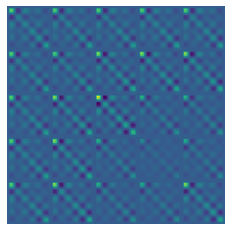

In [9]:
import numpy as np
timepoints = 20
t_temp = torch.linspace(0, 12, timepoints, dtype=torch.float64)
initial_value = torch.zeros((options.num_samples, 5, 1))
samples = model(t_temp, initial_value, return_samples=True, rtol=1e-1, atol=1e-3)
samples = samples.detach().numpy()
fig, ax = plt.subplots(nrows=1) #, figsize=(10, 10))
full_cov = np.zeros((timepoints*5, timepoints*5))
for j in range(5):
    x = samples[:, :, j].squeeze()
    covxx = np.cov(x)
    full_cov[j*timepoints:(j+1)*timepoints, j*timepoints:(j+1)*timepoints] = covxx

    for k in range(j+1, 5):
        y = samples[:,:, j+1].squeeze()
        covxy = np.cov(x, y)
        full_cov[j*timepoints:(j+1)*timepoints, k*timepoints:(k+1)*timepoints] = covxy[:timepoints, timepoints:]
        full_cov[k*timepoints:(k+1)*timepoints, j*timepoints:(j+1)*timepoints] = covxy[:timepoints, timepoints:]

ax.imshow(full_cov)
plt.axis('off')

In [ ]:
# mu = samples.mean(axis=1).reshape(-1)
# mu = torch.tensor(mu, dtype=torch.float32)
# cov = torch.tensor(full_cov, dtype=torch.float32) + torch.eye(5*timepoints) * 1e-1
# print(mu.shape, cov.shape)
# post_dist = torch.distributions.MultivariateNormal(mu, cov)
# fig, ax = plt.subplots(nrows=num_genes, figsize=(5, 10))
# for j in range(num_genes):
#     ax[j].plot(mu.view(timepoints, num_genes)[:, j])
#     for _ in range(10):
#         sample = post_dist.sample().view(timepoints, num_genes)
#         ax[j].plot(sample[:, j])


In [ ]:
save(model, 'variational_linear')

In [ ]:
do_load = False
if do_load:
    model = load('variational_linear', SingleLinearLFM, num_genes, num_tfs,
                 t_inducing, dataset, extra_points=2, fixed_variance=dataset.variance)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    trainer = P53ConstrainedTrainer(model, optimizer, dataset)
print(do_load)